In [1]:
import numpy as np
from models import RegressionFNP
from sklearn.preprocessing import StandardScaler
import torch
from torch.optim import Adam
from scipy.signal import savgol_filter
import warnings
import math
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid', 'seaborn-colorblind', 'seaborn-notebook'])

warnings.filterwarnings('ignore')

## Regression examples

In this part of the notebook we will illustrate how we can use the FNP model in the simple regression task we used in the paper. We will first define auxiliary functions that perform the visualization and return the example dataset.

In [2]:
def visualize(model, dx, stdx, stdy, cond_x=None, cond_y=None, all_x=None, all_y=None, samples=30, 
              range_y=(-100., 100.), title='', train=False):
    '''
    Visualizes the predictive distribution
    '''
    dxy = np.zeros((dx.shape[0], samples))
    if not train:
        model.eval()
    with torch.no_grad():
        dxi = torch.from_numpy(stdx.transform(dx).astype(np.float32))
        if torch.cuda.is_available():
            dxi = dxi.cuda()
        for j in range(samples):
            dxy[:, j] = model.predict(dxi, cond_x, cond_y).ravel()
    print()

    plt.figure()
    mean_dxy, std_dxy = dxy.mean(axis=1), dxy.std(axis=1)
    # smooth it in order to avoid the sampling jitter
    mean_dxys = savgol_filter(mean_dxy, 61, 3)
    std_dxys = savgol_filter(std_dxy, 61, 3)
    
    if torch.cuda.is_available():
        all_x, all_y, cond_x, cond_y = all_x.cpu(), all_y.cpu(), cond_x.cpu(), cond_y.cpu()

    plt.plot(dx.ravel(), mean_dxys, label='Mean function')
    plt.plot(stdx.inverse_transform(all_x.data.numpy()).ravel(), stdy.inverse_transform(all_y.data.numpy()).ravel(), 'o',
             label='Observations')
    if cond_x is not None:
        plt.plot(stdx.inverse_transform(cond_x.data.numpy()).ravel(), stdy.inverse_transform(cond_y.data.numpy()).ravel(), 'o',
             label='Reference')
    plt.fill_between(dx.ravel(), mean_dxys-1.*std_dxys, mean_dxys+1.*std_dxys, alpha=.1)
    plt.fill_between(dx.ravel(), mean_dxys-2.*std_dxys, mean_dxys+2.*std_dxys, alpha=.1)
    plt.fill_between(dx.ravel(), mean_dxys-3.*std_dxys, mean_dxys+3.*std_dxys, alpha=.1)

    plt.xlim([np.min(dx), np.max(dx)])
    plt.ylim(range_y)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3, fancybox=False, shadow=False)
    plt.title(title)
    model.train()
    plt.show()

def dataset():
    N, num_extra = 20, 500
    np.random.seed(1)
    x = np.concatenate([np.random.uniform(low=0, high=0.6, size=(N-8, 1)),
                        np.random.uniform(low=0.8, high=1., size=(8, 1))], axis=0)
    offset = 0.1
    eps = np.random.normal(0., 0.03, size=(x.shape[0], 1))
    f = lambda x, eps: x + np.sin(4 * (x + eps)) + np.sin(13 * (x + eps)) + eps
    y = f(x, eps)
    
    dx = np.linspace(-1., 2., num_extra).astype(np.float32)[:, np.newaxis]
    return x, y, dx

We will then train the FNP model and visualize the loss and predictive distribution during training,

Epoch 0/2000, loss: 3.521



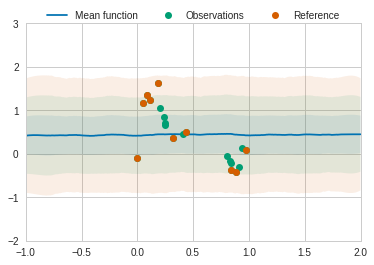

Epoch 400/2000, loss: 0.635



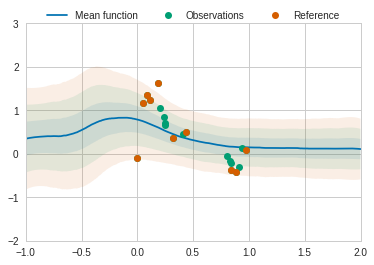

Epoch 800/2000, loss: -1.124



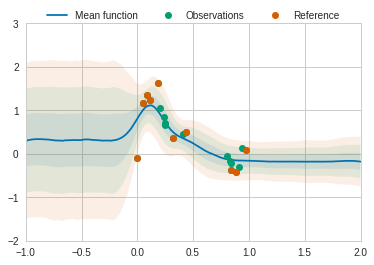

Epoch 1200/2000, loss: -1.344



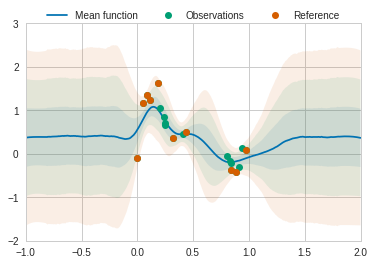

Epoch 1600/2000, loss: -2.090



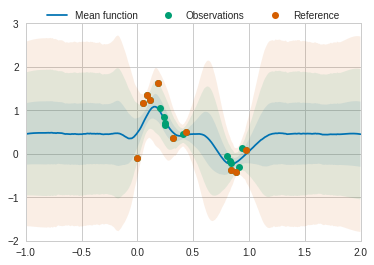

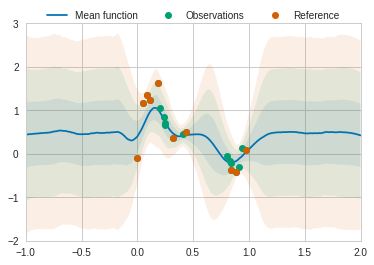

Done.


In [3]:
X, y, dx = dataset()

stdx, stdy = StandardScaler().fit(X), StandardScaler().fit(y)
X, y = stdx.transform(X), stdy.transform(y)
idx = np.arange(X.shape[0])
idxR = np.random.choice(idx, size=(10,), replace=False)
idxM = np.array([i for i in idx if i not in idxR.tolist()])

XR, yR = torch.from_numpy(X[idxR].astype(np.float32)), torch.from_numpy(y[idxR].astype(np.float32))
XM, yM = torch.from_numpy(X[idxM].astype(np.float32)), torch.from_numpy(y[idxM].astype(np.float32))
X, y = torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32))
 

torch.manual_seed(5)
fnp = RegressionFNP(dim_x=1, dim_y=1, transf_y=stdy, dim_h=100, dim_u=3, n_layers=1, num_M=XM.size(0), 
                    dim_z=50, fb_z=1.0, use_plus=False)

if torch.cuda.is_available():
    XR, XM, X = XR.cuda(), XM.cuda(), X.cuda()
    yR, yM, y = yR.cuda(), yM.cuda(), y.cuda()
    fnp = fnp.cuda()
    
optimizer = Adam(fnp.parameters(), lr=1e-3)
fnp.train()


epochs = 2000
for i in range(epochs):
    optimizer.zero_grad()
    
    loss = fnp(XR, yR, XM, yM)
    loss.backward()
    optimizer.step()
        
    if i % int(epochs / 5) == 0:
        print('Epoch {}/{}, loss: {:.3f}'.format(i, epochs, loss.item()))
        visualize(fnp, dx, stdx, stdy, cond_x=XR, cond_y=yR, all_x=X, all_y=y, range_y=(-2., 3.), samples=100)
visualize(fnp, dx, stdx, stdy, cond_x=XR, cond_y=yR, all_x=X, all_y=y, range_y=(-2., 3.), samples=100)
print('Done.')

and then we will train the FNP$^+$ on the same dataset with the same reference set.

Epoch 0/2000, loss: 2.951



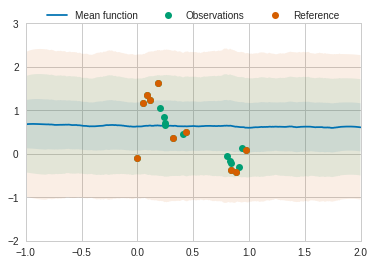

Epoch 400/2000, loss: -0.830



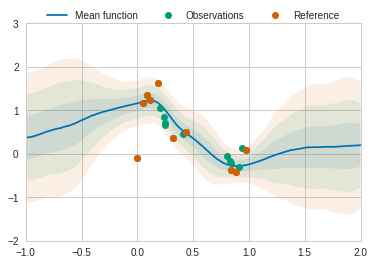

Epoch 800/2000, loss: -2.109



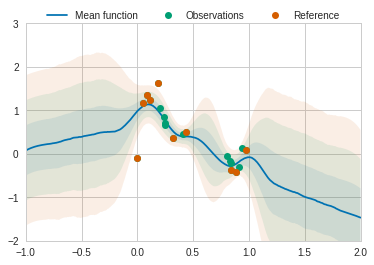

Epoch 1200/2000, loss: -2.199



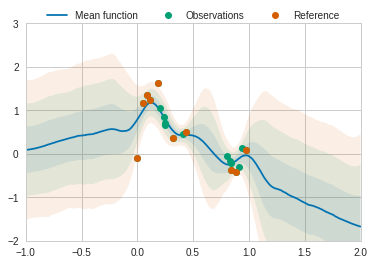

Epoch 1600/2000, loss: -2.361



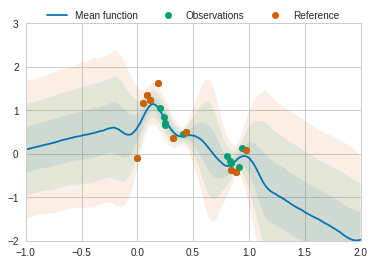

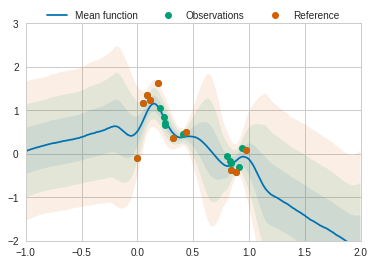

Done.


In [4]:
X, y, dx = dataset()

stdx, stdy = StandardScaler().fit(X), StandardScaler().fit(y)
X, y = stdx.transform(X), stdy.transform(y)
idx = np.arange(X.shape[0])
idxR = np.random.choice(idx, size=(10,), replace=False)
idxM = np.array([i for i in idx if i not in idxR.tolist()])

XR, yR = torch.from_numpy(X[idxR].astype(np.float32)), torch.from_numpy(y[idxR].astype(np.float32))
XM, yM = torch.from_numpy(X[idxM].astype(np.float32)), torch.from_numpy(y[idxM].astype(np.float32))
X, y = torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32))

torch.manual_seed(5)
# We need to increase the free bits for this model to prevent U dominating Z
fnp_plus = RegressionFNP(dim_x=1, dim_y=1, transf_y=stdy, dim_h=100, dim_u=3, n_layers=1, 
                         num_M=XM.size(0), dim_z=50, fb_z=3.0, use_plus=True)

if torch.cuda.is_available():
    XR, XM, X = XR.cuda(), XM.cuda(), X.cuda()
    yR, yM, y = yR.cuda(), yM.cuda(), y.cuda()
    fnp_plus = fnp_plus.cuda()

optimizer = Adam(fnp_plus.parameters(), lr=1e-3, weight_decay=0.)
fnp_plus.train()


epochs = 2000
for i in range(epochs):
    optimizer.zero_grad()
    
    loss = fnp_plus(XR, yR, XM, yM)
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(model11.parameters(), 1.)
    optimizer.step()
    
#     new_fb = - (fb_init / ep_e) * i + fb_init * (1. + (ep_s / ep_e))    
#     model11.fb = min(fb_init, max(new_fb, 0))
        
    if i % int(epochs / 5) == 0:
        print('Epoch {}/{}, loss: {:.3f}'.format(i, epochs, loss.item()))
        visualize(fnp_plus, dx, stdx, stdy, cond_x=XR, cond_y=yR, all_x=X, all_y=y, range_y=(-2., 3.), samples=100)
visualize(fnp_plus, dx, stdx, stdy, cond_x=XR, cond_y=yR, all_x=X, all_y=y, range_y=(-2., 3.), samples=100)
print('Done.')

## Classification example

In this part of the notebook we will show how we can use the FNP in the classification setting by using the simple MNIST dataset.

In [5]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.utils.data as data_utils
from models import ClassificationFNP
from tqdm import tqdm_notebook as tqdm
from PIL import Image

def get_training_reference_set(num_ref=300, seed=1):
    np.random.seed(seed)
    
    training_set = MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
    reference_set_idx = np.random.choice(range(len(training_set)), size=(num_ref,), replace=False)
    training_set_idx = [i for i in range(len(training_set)) if i not in reference_set_idx]

    ref_imgs, ref_lbls = training_set.train_data[reference_set_idx], training_set.train_labels[reference_set_idx]
    train_imgs, train_lbls = training_set.train_data[training_set_idx], training_set.train_labels[training_set_idx]
    
    ref_imgs = ref_imgs[:, None, :, :].float().div(255)

    training_set.train_data = train_imgs
    training_set.train_labels = train_lbls
    if torch.cuda.is_available():
        ref_imgs = ref_imgs.cuda()
        ref_lbls = ref_lbls.cuda()
    
    return training_set, ref_imgs, ref_lbls

def accuracy(data_loader, model, ref_imgs, ref_lbls, n_samples=100):
    model.eval()
    with torch.no_grad():
        acc = 0
        tq_val = tqdm(data_loader, desc="Computing acc.")
        for x, y in tq_val:
            if torch.cuda.is_available():
                x = x.cuda()
            preds = model.predict(x, ref_imgs, ref_lbls, n_samples=n_samples)
            if torch.cuda.is_available():
                preds = preds.cpu().data.numpy()
            else:
                preds = preds.data.numpy()
            acc_b = np.sum(preds == y.data.numpy())
            tq_val.set_postfix_str("Acc: {:.3f}".format(acc_b))
            acc += acc_b
    tq_val.close()
    model.train()
    return 100 * (acc / (1. * data_loader.dataset.test_data.size(0)))

In [6]:
training_set, ref_imgs, ref_lbls = get_training_reference_set()

train_loader = data_utils.DataLoader(training_set, batch_size=100, shuffle=True)
test_loader = data_utils.DataLoader(MNIST('../data', train=False, download=True, transform=transforms.ToTensor()),
                                    batch_size=100, shuffle=False)

fnp = ClassificationFNP(num_M=len(train_loader))
if torch.cuda.is_available():
    fnp = fnp.cuda()

optimizer = Adam(fnp.parameters())

fnp.train()
tot_epochs = 10
for epoch in range(tot_epochs):
    tot_loss = 0.
    tq_train = tqdm(train_loader, desc="Epoch {}/{}".format(epoch + 1, tot_epochs))
    for i, (x, y) in enumerate(tq_train):
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        loss = fnp(x, y, ref_imgs, ref_lbls)
    
        loss.backward()
        optimizer.step()
        
        if math.isnan(loss.item()):
            raise Exception
        
        tot_loss += loss.item()
        tq_train.set_postfix_str("Loss: {:.3f}".format(loss.item()))

    tq_train.close()
    acc = accuracy(test_loader, fnp, ref_imgs, ref_lbls, n_samples=10)
    print('Epoch {}/{}, loss: {:.3f}, test_acc: {:.2f}\n'.format(epoch + 1, tot_epochs, 
                                                               tot_loss / len(train_loader), acc))
    
acc = accuracy(test_loader, fnp, ref_imgs, ref_lbls, n_samples=100)
print('Final accuracy: {:.2f}'.format(acc))


Epoch 1/10, loss: 0.262, test_acc: 95.81




Epoch 2/10, loss: 0.055, test_acc: 98.17




Epoch 3/10, loss: 0.037, test_acc: 98.43




Epoch 4/10, loss: 0.029, test_acc: 98.70




Epoch 5/10, loss: 0.022, test_acc: 98.85




Epoch 6/10, loss: 0.018, test_acc: 98.93




Epoch 7/10, loss: 0.015, test_acc: 98.81




Epoch 8/10, loss: 0.014, test_acc: 99.12




Epoch 9/10, loss: 0.012, test_acc: 99.06




Epoch 10/10, loss: 0.009, test_acc: 98.99




Final accuracy: 98.98


Thus we can see that the model reaches decent accuracy in just 10 epochs. Now we will evaluate its predictive uncertainty on a out-of-distribution detection task, by using FashionMNIST as the o.o.d. dataset. We would ideally like to have much higher entropy in the predictive distribution for the o.o.d. dataset, compared to the entropy we get on the actual in-distribution dataset, i.e. MNIST.

In [7]:
from torchvision.datasets import FashionMNIST

def entropy(data_loader, model, ref_imgs, ref_lbls):
    with torch.no_grad():
        entr, N = 0., 0.
        tq_entr = tqdm(data_loader, desc='Computing entr.')
        for i, (x, _) in enumerate(tq_entr):
            if torch.cuda.is_available():
                x = x.cuda()

            N += float(x.size(0))

            ps = torch.softmax(model.get_pred_logits(x, ref_imgs, ref_lbls), 1).detach()
            ps = torch.clamp(ps, min=1e-5, max=1-1e-5)
            entr += torch.sum(-torch.sum(ps * ps.log(), dim=1)).item()
        tq_entr.close()
    entr /= N
    return entr

fnp.eval()

ood_data = data_utils.DataLoader(FashionMNIST(root='../data/fmnist', train=False, download=True, 
                                              transform=transforms.ToTensor()), batch_size=100, shuffle=False)
entr_in = entropy(test_loader, fnp, ref_imgs, ref_lbls)
entr_out = entropy(ood_data, fnp, ref_imgs, ref_lbls)

print('I.D. entropy: {:.3f}, O.O.D. entropy: {:.3f}'.format(entr_in, entr_out))


I.D. entropy: 0.073, O.O.D. entropy: 1.768


We see that the model has much higher average entropy on the o.o.d. dataset, which is exactly what we wanted!